In [1]:
import os
import shutil
from sklearn.model_selection import train_test_split

# Define the path to the input dataset
input_dir = '/kaggle/input/cotton-leaf-dataset/Augmented Dataset/Augmented Dataset'

# Define the path to the working directory where we will save the split data
working_dir = '/kaggle/working/cotton-leaf-dataset-split'

# Create directories for train, validation, and test datasets in the working directory
train_dir = os.path.join(working_dir, 'train')
val_dir = os.path.join(working_dir, 'val')
test_dir = os.path.join(working_dir, 'test')

os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# Get list of all the classes in the dataset
classes = os.listdir(input_dir)
# Split the data for each class into train, test, and validation
for class_name in classes:
    class_path = os.path.join(input_dir, class_name)
    if os.path.isdir(class_path):
        # Get all image files for the class
        all_files = os.listdir(class_path)
        
        # Shuffle and split the data
        train_files, temp_files = train_test_split(all_files, test_size=0.3, random_state=42)
        val_files, test_files = train_test_split(temp_files, test_size=2/3, random_state=42)  # 10% for validation
        
        # Create class directories in train, val, and test
        os.makedirs(os.path.join(train_dir, class_name), exist_ok=True)
        os.makedirs(os.path.join(val_dir, class_name), exist_ok=True)
        os.makedirs(os.path.join(test_dir, class_name), exist_ok=True)
        
        # Move the files to respective directories in the working directory
        for file in train_files:
            shutil.copy(os.path.join(class_path, file), os.path.join(train_dir, class_name, file))
        for file in val_files:
            shutil.copy(os.path.join(class_path, file), os.path.join(val_dir, class_name, file))
        for file in test_files:
            shutil.copy(os.path.join(class_path, file), os.path.join(test_dir, class_name, file))

print("Data has been split and saved in the working directory.")


Data has been split and saved in the working directory.


In [2]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.preprocessing import LabelBinarizer

In [3]:
# Set the path to the working directory containing train, validation, and test data
train_dir = '/kaggle/working/cotton-leaf-dataset-split/train'
val_dir = '/kaggle/working/cotton-leaf-dataset-split/val'
test_dir = '/kaggle/working/cotton-leaf-dataset-split/test'

# Define learning rate and other hyperparameters
initial_lr = 0.0001  # Learning rate
batch_size = 32
epochs = 50

# Set up data generators for train, validation, and test sets
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(train_dir,
                                                    target_size=(224, 224),
                                                    batch_size=batch_size,
                                                    class_mode='categorical')

val_generator = val_datagen.flow_from_directory(val_dir,
                                                target_size=(224, 224),
                                                batch_size=batch_size,
                                                class_mode='categorical')

test_generator = test_datagen.flow_from_directory(test_dir,
                                                  target_size=(224, 224),
                                                  batch_size=batch_size,
                                                  class_mode='categorical',
                                                  shuffle=False)

Found 4900 images belonging to 7 classes.
Found 700 images belonging to 7 classes.
Found 1400 images belonging to 7 classes.


In [4]:

# Define the Xception model with pre-trained weights (without top layer for custom output)
base_model = tf.keras.applications.Xception(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers of the base model
base_model.trainable = False

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [5]:

# Add custom layers on top of the Xception base model
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(train_generator.num_classes, activation='softmax')
])

In [6]:
# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=initial_lr),
              loss='categorical_crossentropy',
              metrics=['accuracy'])


In [7]:
# Learning rate scheduler
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1)

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)

# Train the model
history = model.fit(train_generator,
                    epochs=epochs,
                    validation_data=val_generator,
                    callbacks=[early_stopping, lr_scheduler])


Epoch 1/50


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1732900986.607821     123 service.cc:145] XLA service 0x7c7af00387e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1732900986.607891     123 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


  2/154 ━━━━━━━━━━━━━━━━━━━━ 11s 77ms/step - accuracy: 0.0625 - loss: 2.1145 

I0000 00:00:1732900994.236060     123 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


154/154 ━━━━━━━━━━━━━━━━━━━━ 53s 261ms/step - accuracy: 0.3659 - loss: 1.6706 - val_accuracy: 0.7214 - val_loss: 0.9609 - learning_rate: 1.0000e-04
Epoch 2/50
154/154 ━━━━━━━━━━━━━━━━━━━━ 30s 189ms/step - accuracy: 0.6733 - loss: 0.9904 - val_accuracy: 0.7700 - val_loss: 0.7442 - learning_rate: 1.0000e-04
Epoch 3/50
154/154 ━━━━━━━━━━━━━━━━━━━━ 29s 177ms/step - accuracy: 0.7409 - loss: 0.8107 - val_accuracy: 0.8129 - val_loss: 0.6294 - learning_rate: 1.0000e-04
Epoch 4/50
154/154 ━━━━━━━━━━━━━━━━━━━━ 28s 177ms/step - accuracy: 0.7753 - loss: 0.6763 - val_accuracy: 0.8343 - val_loss: 0.5572 - learning_rate: 1.0000e-04
Epoch 5/50
154/154 ━━━━━━━━━━━━━━━━━━━━ 29s 182ms/step - accuracy: 0.8024 - loss: 0.6318 - val_accuracy: 0.8500 - val_loss: 0.5055 - learning_rate: 1.0000e-04
Epoch 6/50
154/154 ━━━━━━━━━━━━━━━━━━━━ 29s 182ms/step - accuracy: 0.8256 - loss: 0.5507 - val_accuracy: 0.8514 - val_loss: 0.4744 - learning_rate: 1.0000e-04
Epoch 7/50
154/154 ━━━━━━━━━━━━━━━━━━━━ 29s 178ms/step - 

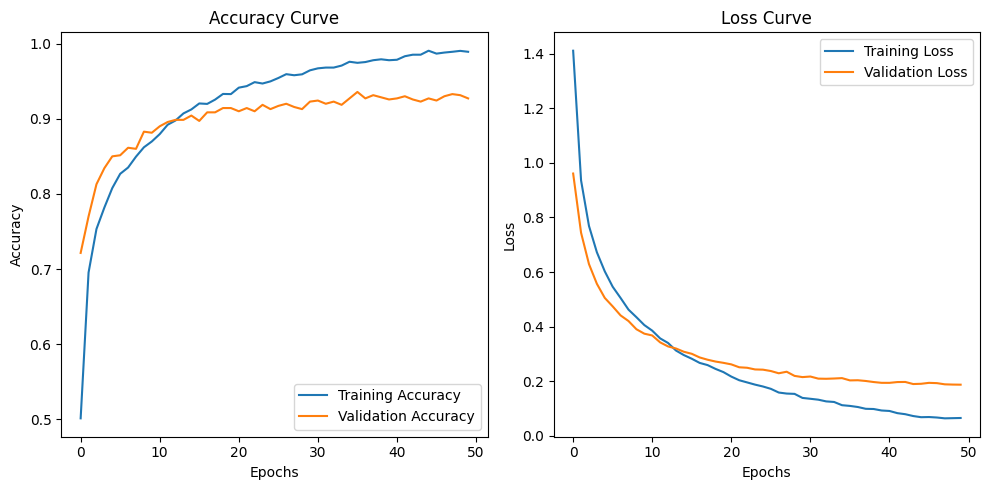

44/44 - 11s - 245ms/step - accuracy: 0.9171 - loss: 0.2408
Test Accuracy: 0.9171428680419922
Test Loss: 0.24077032506465912
44/44 ━━━━━━━━━━━━━━━━━━━━ 11s 199ms/step


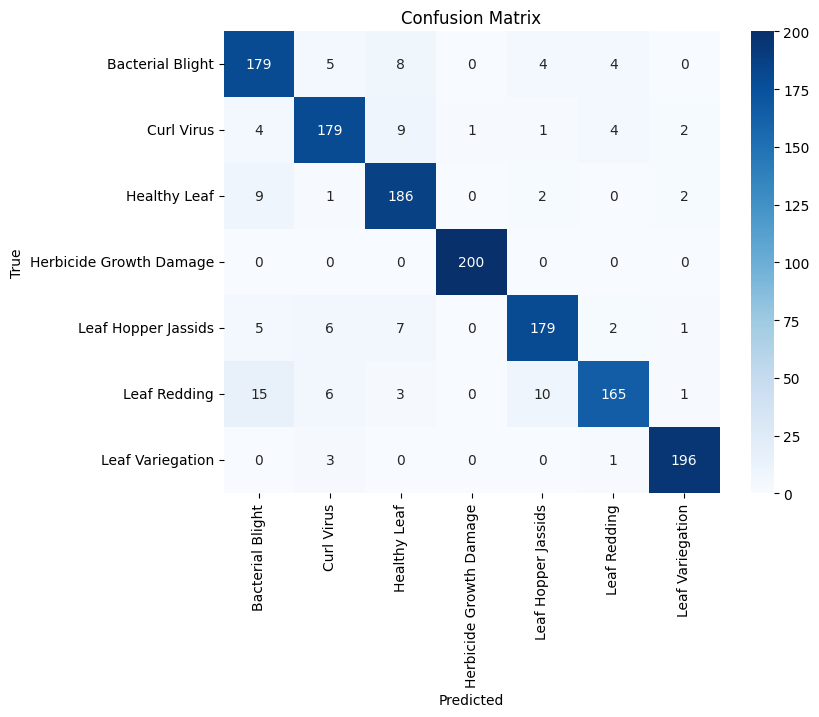

Overall Accuracy: 91.71%
Overall Precision: 91.84%
Overall Recall: 91.71%
Overall F1 Score: 91.70%

Classification Report:
                          precision    recall  f1-score   support

       Bacterial Blight       0.84      0.90      0.87       200
             Curl Virus       0.90      0.90      0.90       200
           Healthy Leaf       0.87      0.93      0.90       200
Herbicide Growth Damage       1.00      1.00      1.00       200
    Leaf Hopper Jassids       0.91      0.90      0.90       200
           Leaf Redding       0.94      0.82      0.88       200
       Leaf Variegation       0.97      0.98      0.98       200

               accuracy                           0.92      1400
              macro avg       0.92      0.92      0.92      1400
           weighted avg       0.92      0.92      0.92      1400



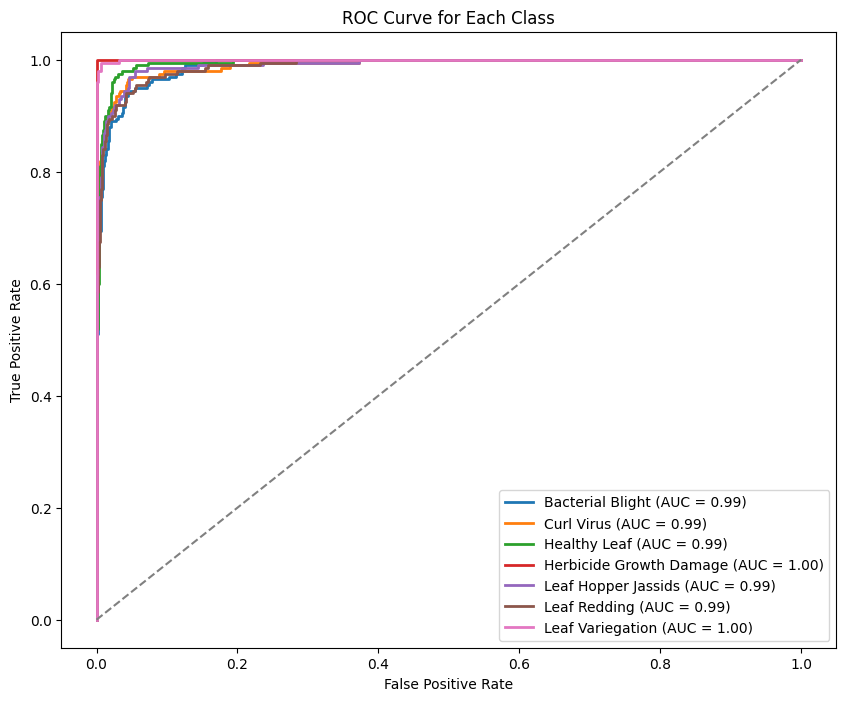

In [8]:
# Plot accuracy and loss curves
def plot_history(history):
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy Curve')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss Curve')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_history(history)

# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(test_generator, verbose=2)
print(f"Test Accuracy: {test_acc}")
print(f"Test Loss: {test_loss}")

# Get predictions on the test set
y_true = test_generator.classes
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)

# Confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=test_generator.class_indices.keys(),
            yticklabels=test_generator.class_indices.keys())
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Compute overall accuracy, precision, recall, and F1-score
accuracy = accuracy_score(y_true, y_pred_classes)
precision = precision_score(y_true, y_pred_classes, average='weighted')
recall = recall_score(y_true, y_pred_classes, average='weighted')
f1 = f1_score(y_true, y_pred_classes, average='weighted')

# Print the overall metrics
print("Overall Accuracy: {:.2f}%".format(accuracy * 100))
print("Overall Precision: {:.2f}%".format(precision * 100))
print("Overall Recall: {:.2f}%".format(recall * 100))
print("Overall F1 Score: {:.2f}%".format(f1 * 100))

# Classification report
print("\nClassification Report:\n", classification_report(y_true, y_pred_classes, target_names=test_generator.class_indices.keys()))

# Plot ROC curve for each class
lb = LabelBinarizer()
y_true_bin = lb.fit_transform(y_true)
n_classes = y_true_bin.shape[1]
class_names = list(test_generator.class_indices.keys())

plt.figure(figsize=(10, 8))
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_pred[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'{class_names[i]} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.title('ROC Curve for Each Class')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()